In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import KDTree

In [65]:
file_path = '/content/SMILES_Big_Data_Set.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
data.head()

,SMILES,pIC50,mol,num_atoms,logP
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26,<rdkit.Chem.rdchem.Mol object at 0x7f59df45bc30>,25,4.1591
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c9e0>,36,3.6743
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cac0>,23,1.5361
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56,<rdkit.Chem.rdchem.Mol object at 0x7f59a320cba0>,22,0.9510
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59,<rdkit.Chem.rdchem.Mol object at 0x7f59a320c7b0>,21,3.2130


In [66]:
X = data[['num_atoms', 'logP']].values

**Parameters**

In [74]:
eps = 0.4 #epsilon
min_pts = 5 #min neighbors to be core point

**Distance Function**



In [68]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2) ** 2))

**Record Neighbors**

*We need a function to find all the points in the dataset that are within eps distance from a given point.*



In [69]:
def get_neighbors(X, point_idx, eps, tree):
    neighbors = tree.query_ball_point(X[point_idx], eps)
    return neighbors

**Expand Cluster**

*This function will expand the cluster from a given point and its neighbors, marking points as part of a cluster or noise.*

In [70]:
def expand_cluster(X, labels, point_idx, cluster_id, eps, min_pts, tree):
    neighbors = get_neighbors(X, point_idx, eps, tree)

    if len(neighbors) < min_pts:
        labels[point_idx] = -1  # Mark as noise
        return False
    else:
        labels[point_idx] = cluster_id
        queue = neighbors

        while queue:
            current_point_idx = queue.pop(0)
            if labels[current_point_idx] == 0:  # Unvisited point
                labels[current_point_idx] = cluster_id
                current_neighbors = get_neighbors(X, current_point_idx, eps, tree)
                if len(current_neighbors) >= min_pts:
                    queue.extend(current_neighbors)

        return True

**Main DBSCAN Function**

In [71]:
def dbscan(X, eps, min_pts):
    labels = np.zeros(len(X))  # Initialize labels as 0 (unvisited)
    cluster_id = 0
    tree = KDTree(X)

    for point_idx in range(len(X)):
        if labels[point_idx] == 0:  # Only unvisited points
            if expand_cluster(X, labels, point_idx, cluster_id + 1, eps, min_pts, tree):
                cluster_id += 1

    return labels

# **Lets try how it works**

In [75]:
labels = dbscan(X, eps, min_pts)
labels

array([ 1.,  2.,  3., ..., 24.,  4., 29.])

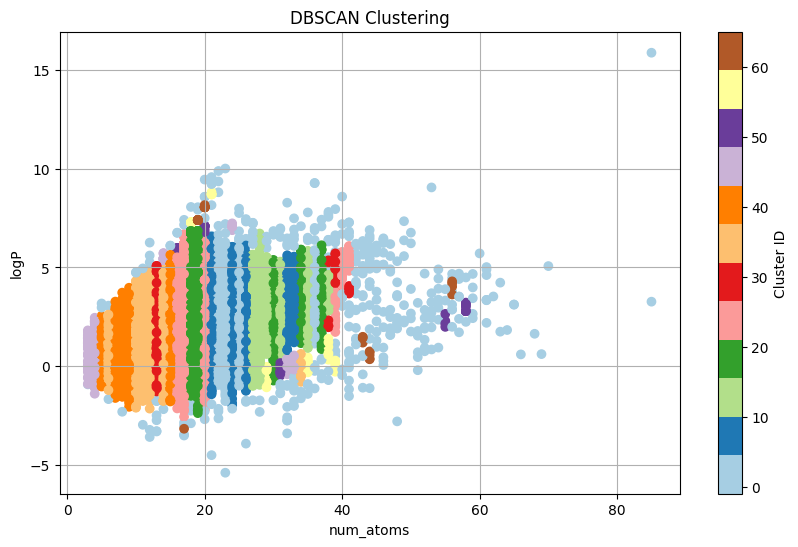

In [76]:
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='Paired')
plt.xlabel('num_atoms')
plt.ylabel('logP')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster ID')
plt.show()

**The light blue ones are the outliers**